In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "none"

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, auc, precision_score, recall_score
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pickle
from math import ceil

pd.options.display.float_format = '{:,.2f}'.format

target_source = pd.read_csv('../data/raw/target_apartments.csv')

In [2]:
classifier = pickle.load(open("../models/classifier.pickle.pkl", "rb"))
valueregr = pickle.load(open("../models/value-regressor.pickle.pkl", "rb"))
ntvalueregr = pickle.load(open("../models/value-regressor-notime.pickle.pkl", "rb"))
timeregr = pickle.load(open("../models/time-regressor.pickle.pkl", "rb"))

## Usando modelo sem tempo previsto de venda para prever o valor esperado

In [3]:
ntvalueregr_target = target_source.copy()

### Prevendo com interior quality máximo
resell = ntvalueregr_target.drop('value',axis=1)
resell['interior_quality'] = 3

ntvalueregr_target['pred_nt_value'] = ntvalueregr.predict(resell)

ntvalueregr_target.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,pred_nt_value
0,2.00,1.00,57,-23.61,-46.63,454377,2,"488,744.03"
1,3.00,2.00,120,-23.56,-46.66,1500960,1,"1,384,365.38"
2,2.00,2.00,80,-23.56,-46.70,1045980,3,"988,797.50"
3,3.00,4.00,500,-23.51,-46.65,3707770,3,"3,539,147.75"
4,3.00,2.00,122,-23.52,-46.72,1007670,2,"1,261,779.12"


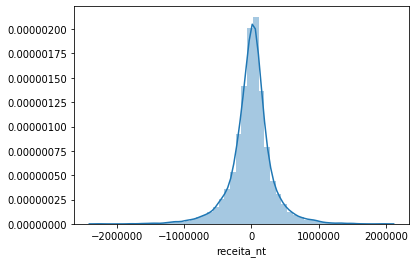

In [4]:
ntvalueregr_target['receita_nt'] = ntvalueregr_target['pred_nt_value'] - ntvalueregr_target['value']

sns.distplot(ntvalueregr_target['receita_nt'])

In [5]:
ntvalueregr_target['sinal_receita_nt'] = ntvalueregr_target.receita_nt.apply(np.sign)

ntvalueregr_target.groupby('interior_quality')['sinal_receita_nt'].value_counts(normalize=True)

interior_quality  sinal_receita_nt
1                 1.00               0.53
                  -1.00              0.47
2                 1.00               0.51
                  -1.00              0.49
3                 1.00               0.54
                  -1.00              0.46
Name: sinal_receita_nt, dtype: float64

In [6]:
ntvalueregr_target.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,pred_nt_value,receita_nt,sinal_receita_nt
0,2.00,1.00,57,-23.61,-46.63,454377,2,"488,744.03","34,367.03",1.00
1,3.00,2.00,120,-23.56,-46.66,1500960,1,"1,384,365.38","-116,594.62",-1.00
2,2.00,2.00,80,-23.56,-46.70,1045980,3,"988,797.50","-57,182.50",-1.00
3,3.00,4.00,500,-23.51,-46.65,3707770,3,"3,539,147.75","-168,622.25",-1.00
4,3.00,2.00,122,-23.52,-46.72,1007670,2,"1,261,779.12","254,109.12",1.00


In [7]:
ntvalueregr_target['sinal_receita_nt'].value_counts()

1.00     4426
-1.00    3942
Name: sinal_receita_nt, dtype: int64

## Previsão do tempo esperando para venda com base no preço previsto

In [8]:
timeregr_target = ntvalueregr_target.copy()
cols = target_source.columns.values

timeregr_target['pred_time_on_market_source'] = timeregr.predict(timeregr_target[cols])

resell = timeregr_target.rename(columns={'value':'drop', 'pred_nt_value':'value'})[cols]
resell['interior_quality'] = 3

timeregr_target['pred_time_on_market_nt_value'] = timeregr.predict(resell)

timeregr_target.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,pred_nt_value,receita_nt,sinal_receita_nt,pred_time_on_market_source,pred_time_on_market_nt_value
0,2.00,1.00,57,-23.61,-46.63,454377,2,"488,744.03","34,367.03",1.00,73.99,70.02
1,3.00,2.00,120,-23.56,-46.66,1500960,1,"1,384,365.38","-116,594.62",-1.00,109.13,120.79
2,2.00,2.00,80,-23.56,-46.70,1045980,3,"988,797.50","-57,182.50",-1.00,147.66,147.66
3,3.00,4.00,500,-23.51,-46.65,3707770,3,"3,539,147.75","-168,622.25",-1.00,114.50,131.75
4,3.00,2.00,122,-23.52,-46.72,1007670,2,"1,261,779.12","254,109.12",1.00,118.99,121.57


In [9]:
cols = target_source.columns.values

timeregr_target[cols]

,rooms,garages,useful_area,latitude,longitude,value,interior_quality
0,2.00,1.00,57,-23.61,-46.63,454377,2
1,3.00,2.00,120,-23.56,-46.66,1500960,1
2,2.00,2.00,80,-23.56,-46.70,1045980,3
3,3.00,4.00,500,-23.51,-46.65,3707770,3
4,3.00,2.00,122,-23.52,-46.72,1007670,2
...,...,...,...,...,...,...,...
8363,3.00,3.00,148,-23.63,-46.70,1276480,3
8364,4.00,4.00,336,-23.59,-46.72,3543890,1
8365,3.00,2.00,110,-23.58,-46.64,1088360,1
8366,3.00,1.00,190,-23.56,-46.67,2727660,1


In [10]:
timeregr_target.rename(columns={'value':'drop', 'pred_time_on_market_nt_value':'value'})[cols]

,rooms,garages,useful_area,latitude,longitude,value,interior_quality
0,2.00,1.00,57,-23.61,-46.63,70.02,2
1,3.00,2.00,120,-23.56,-46.66,120.79,1
2,2.00,2.00,80,-23.56,-46.70,147.66,3
3,3.00,4.00,500,-23.51,-46.65,131.75,3
4,3.00,2.00,122,-23.52,-46.72,121.57,2
...,...,...,...,...,...,...,...
8363,3.00,3.00,148,-23.63,-46.70,123.65,3
8364,4.00,4.00,336,-23.59,-46.72,199.25,1
8365,3.00,2.00,110,-23.58,-46.64,97.84,1
8366,3.00,1.00,190,-23.56,-46.67,154.55,1


119.93558

111.891304

rooms
1.00   110.78
2.00   108.70
3.00   118.39
4.00   137.04
5.00   133.07
6.00   162.48
Name: pred_time_on_market_nt_value, dtype: float32

rooms
1.00   102.53
2.00   104.66
3.00   110.33
4.00   124.64
5.00   135.67
6.00   166.20
Name: pred_time_on_market_source, dtype: float32

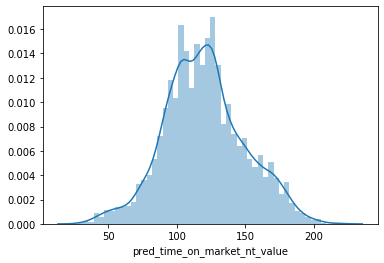

In [11]:
sns.distplot(timeregr_target['pred_time_on_market_nt_value'])

display(timeregr_target['pred_time_on_market_nt_value'].mean(),
        timeregr_target['pred_time_on_market_source'].mean(),
        timeregr_target.groupby('rooms')['pred_time_on_market_nt_value'].mean(),
        timeregr_target.groupby('rooms')['pred_time_on_market_source'].mean())

In [12]:
## Bin em quinzenas
bins = [15*x for x in range((360//15)+1)]
timeregr_target['time_on_market_agg'] = pd.cut(timeregr_target['pred_time_on_market_nt_value'],bins)

timeregr_target.groupby('time_on_market_agg')['value'].mean()

time_on_market_agg
(0, 15]               nan
(15, 30]       422,468.67
(30, 45]       405,360.34
(45, 60]       461,673.39
(60, 75]       569,543.18
(75, 90]       766,399.05
(90, 105]      982,928.96
(105, 120]   1,186,320.78
(120, 135]   1,514,900.96
(135, 150]   1,868,303.31
(150, 165]   2,549,228.50
(165, 180]   3,004,287.68
(180, 195]   3,286,946.49
(195, 210]   2,951,119.84
(210, 225]     845,976.67
(225, 240]            nan
(240, 255]            nan
(255, 270]            nan
(270, 285]            nan
(285, 300]            nan
(300, 315]            nan
(315, 330]            nan
(330, 345]            nan
(345, 360]            nan
Name: value, dtype: float64

In [13]:
timeregr_target

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,pred_nt_value,receita_nt,sinal_receita_nt,pred_time_on_market_source,pred_time_on_market_nt_value,time_on_market_agg
0,2.00,1.00,57,-23.61,-46.63,454377,2,"488,744.03","34,367.03",1.00,73.99,70.02,"(60, 75]"
1,3.00,2.00,120,-23.56,-46.66,1500960,1,"1,384,365.38","-116,594.62",-1.00,109.13,120.79,"(120, 135]"
2,2.00,2.00,80,-23.56,-46.70,1045980,3,"988,797.50","-57,182.50",-1.00,147.66,147.66,"(135, 150]"
3,3.00,4.00,500,-23.51,-46.65,3707770,3,"3,539,147.75","-168,622.25",-1.00,114.50,131.75,"(120, 135]"
4,3.00,2.00,122,-23.52,-46.72,1007670,2,"1,261,779.12","254,109.12",1.00,118.99,121.57,"(120, 135]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8363,3.00,3.00,148,-23.63,-46.70,1276480,3,"1,593,822.38","317,342.38",1.00,103.02,123.65,"(120, 135]"
8364,4.00,4.00,336,-23.59,-46.72,3543890,1,"3,738,609.50","194,719.50",1.00,115.03,199.25,"(195, 210]"
8365,3.00,2.00,110,-23.58,-46.64,1088360,1,"1,020,251.56","-68,108.44",-1.00,129.79,97.84,"(90, 105]"
8366,3.00,1.00,190,-23.56,-46.67,2727660,1,"2,236,008.25","-491,651.75",-1.00,126.95,154.55,"(150, 165]"


In [14]:
### Receita por unidade de tempo
timeregr_target['receita_tempo'] = timeregr_target['receita_nt'] / timeregr_target['pred_time_on_market_nt_value']

In [15]:
timeregr_target

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,pred_nt_value,receita_nt,sinal_receita_nt,pred_time_on_market_source,pred_time_on_market_nt_value,time_on_market_agg,receita_tempo
0,2.00,1.00,57,-23.61,-46.63,454377,2,"488,744.03","34,367.03",1.00,73.99,70.02,"(60, 75]",490.80
1,3.00,2.00,120,-23.56,-46.66,1500960,1,"1,384,365.38","-116,594.62",-1.00,109.13,120.79,"(120, 135]",-965.30
2,2.00,2.00,80,-23.56,-46.70,1045980,3,"988,797.50","-57,182.50",-1.00,147.66,147.66,"(135, 150]",-387.25
3,3.00,4.00,500,-23.51,-46.65,3707770,3,"3,539,147.75","-168,622.25",-1.00,114.50,131.75,"(120, 135]","-1,279.88"
4,3.00,2.00,122,-23.52,-46.72,1007670,2,"1,261,779.12","254,109.12",1.00,118.99,121.57,"(120, 135]","2,090.31"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8363,3.00,3.00,148,-23.63,-46.70,1276480,3,"1,593,822.38","317,342.38",1.00,103.02,123.65,"(120, 135]","2,566.45"
8364,4.00,4.00,336,-23.59,-46.72,3543890,1,"3,738,609.50","194,719.50",1.00,115.03,199.25,"(195, 210]",977.28
8365,3.00,2.00,110,-23.58,-46.64,1088360,1,"1,020,251.56","-68,108.44",-1.00,129.79,97.84,"(90, 105]",-696.15
8366,3.00,1.00,190,-23.56,-46.67,2727660,1,"2,236,008.25","-491,651.75",-1.00,126.95,154.55,"(150, 165]","-3,181.23"


## Classificação

In [16]:
resell

,rooms,garages,useful_area,latitude,longitude,value,interior_quality
0,2.00,1.00,57,-23.61,-46.63,"488,744.03",3
1,3.00,2.00,120,-23.56,-46.66,"1,384,365.38",3
2,2.00,2.00,80,-23.56,-46.70,"988,797.50",3
3,3.00,4.00,500,-23.51,-46.65,"3,539,147.75",3
4,3.00,2.00,122,-23.52,-46.72,"1,261,779.12",3
...,...,...,...,...,...,...,...
8363,3.00,3.00,148,-23.63,-46.70,"1,593,822.38",3
8364,4.00,4.00,336,-23.59,-46.72,"3,738,609.50",3
8365,3.00,2.00,110,-23.58,-46.64,"1,020,251.56",3
8366,3.00,1.00,190,-23.56,-46.67,"2,236,008.25",3


In [19]:
classifier_target = timeregr_target.copy()
cols = np.append(target_source.columns.values,'time_on_market')

resell = classifier_target.rename(columns={'pred_time_on_market_nt_value':'time_on_market', 
                                          'value':'drop',
                                         'pred_nt_value':'value'})[cols]
resell['interior_quality'] = 3

classifier_target['sold_proba'] = classifier.predict_proba(resell)[:,1]
classifier_target['sold'] = classifier.predict(resell).astype('bool')

classfier_target.head()

,rooms,garages,useful_area,latitude,longitude,value,interior_quality,pred_nt_value,receita_nt,sinal_receita_nt,pred_time_on_market_source,pred_time_on_market_nt_value,time_on_market_agg,receita_tempo,sold_proba,sold
0,2.00,1.00,57,-23.61,-46.63,454377,2,"488,744.03","34,367.03",1.00,73.99,70.02,"(60, 75]",490.80,0.71,True
1,3.00,2.00,120,-23.56,-46.66,1500960,1,"1,384,365.38","-116,594.62",-1.00,109.13,120.79,"(120, 135]",-965.30,0.47,False
2,2.00,2.00,80,-23.56,-46.70,1045980,3,"988,797.50","-57,182.50",-1.00,147.66,147.66,"(135, 150]",-387.25,0.30,False
3,3.00,4.00,500,-23.51,-46.65,3707770,3,"3,539,147.75","-168,622.25",-1.00,114.50,131.75,"(120, 135]","-1,279.88",0.44,False
4,3.00,2.00,122,-23.52,-46.72,1007670,2,"1,261,779.12","254,109.12",1.00,118.99,121.57,"(120, 135]","2,090.31",0.68,True


In [21]:
classifier_target['exp_selling_time'] = classifier_target['pred_time_on_market_nt_value'].apply(ceil)

## Save

In [23]:
classfier_target.to_csv('../data/interim/valuation.csv',index=False)